In [131]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=16)

# Read BT11 and Chavez14

In [132]:
# dataset available here: https://cdsarc.unistra.fr/viz-bin/cat/J/A+A/599/A76
mel17 = pd.concat([pd.read_csv('../data/cha14.csv'),
                   pd.read_csv('../data/bor11.csv')])

In [133]:
mel17.head()

,name,z,sig_5007,er_sig_5007,logLHb,er_logLHb,ewhb,er_ewhb
0,J000657,0.0737,44.8,0.43,41.30,0.01,86.5,2.1
1,J001647,0.0232,21.3,0.89,40.88,0.01,56.9,0.7
2,J002339,0.0531,30.5,0.62,41.32,0.01,110.1,1.3
3,J002425,0.0142,34.9,0.54,40.31,0.01,61.6,0.8
4,J003218,0.0180,38.6,0.49,40.34,0.01,80.0,0.9


In [134]:
mel17.shape

(132, 8)

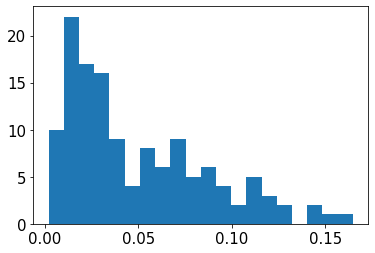

In [135]:
plt.hist(mel17.z, bins=20)
plt.show()

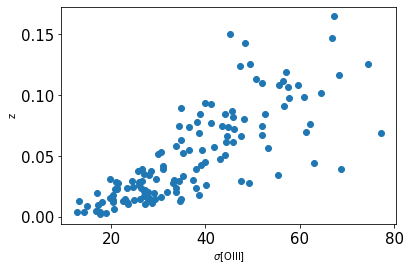

In [136]:
plt.scatter(mel17.sig_5007, mel17.z)
plt.xlabel(r'$\sigma$' '[OIII]')
plt.ylabel('z')
plt.show()

The sample $\sigma-z$ bias was observed in Bordalo (2009) for the full sample of HIIGs (120 objects):
<img src="../data/ls118z.png" width="45%">

# Create a categorical variable for the redshift bins

In [137]:
labels = []
bins = 3
for i in range(bins):
    labels.append('z'+str(i+1))

#create a new column for the z bin
mel17['z_bin'] = pd.cut(mel17['z'], bins=bins, labels=labels)

In [138]:
mel17.head()

,name,z,sig_5007,er_sig_5007,logLHb,er_logLHb,ewhb,er_ewhb,z_bin
0,J000657,0.0737,44.8,0.43,41.30,0.01,86.5,2.1,z2
1,J001647,0.0232,21.3,0.89,40.88,0.01,56.9,0.7,z1
2,J002339,0.0531,30.5,0.62,41.32,0.01,110.1,1.3,z1
3,J002425,0.0142,34.9,0.54,40.31,0.01,61.6,0.8,z1
4,J003218,0.0180,38.6,0.49,40.34,0.01,80.0,0.9,z1


# Undersampling to remove $\sigma-Z$ bias

In [139]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.linear_model import LinearRegression

In [140]:
X = mel17.iloc[:,:-1].to_numpy()
print(X.shape)
y = mel17['z_bin'].to_numpy()
print(y.shape)

(132, 8)
(132,)


In [141]:
Counter(y)

Counter({'z2': 38, 'z1': 83, 'z3': 11})

In [142]:
X_res, y_res = RandomUnderSampler().fit_resample(X, y)

In [143]:
Counter(y_res)

Counter({'z1': 11, 'z2': 11, 'z3': 11})

In [144]:
log_sigma = np.log10(X_res[:,2].astype('float').reshape(-1, 1))
log_L = X_res[:,4].astype('float')

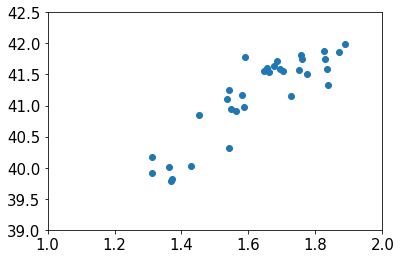

In [145]:
plt.scatter(log_sigma, log_L)
plt.xlim(1,2)
plt.ylim(39,42.5)
plt.show()

# Fit $n$ independent unbias $L-\sigma$ relations

Where $n$ is $C(83,11) \times C(38,11)$ for 3 redshift bins!!

Estimate the coeficients ($\alpha$ and $\beta$) by convergence.

In [146]:
slopes = []
mean_slopes = []

intercepts = []
mean_intercepts = []

scores = []
mean_scores = []

for i in range(10000):
    X_res, y_res = RandomUnderSampler(random_state=i).fit_resample(X, y)
    log_sigma = np.log10(X_res[:,2].astype('float').reshape(-1, 1))
    log_L = X_res[:,4].astype('float')
    reg = LinearRegression().fit(log_sigma, log_L)
    #print('R^2: {}; slope: {}; intercept: {}'.format(reg.score(log_sigma, log_L).round(4), reg.coef_[0].round(3), reg.intercept_.round(3)))

    scores.append(reg.score(log_sigma, log_L))
    mean_scores.append(sum(scores)/len(scores))

    slopes.append(reg.coef_[0])
    mean_slopes.append(sum(slopes)/len(slopes))

    intercepts.append(reg.intercept_)
    mean_intercepts.append(sum(intercepts)/len(intercepts))


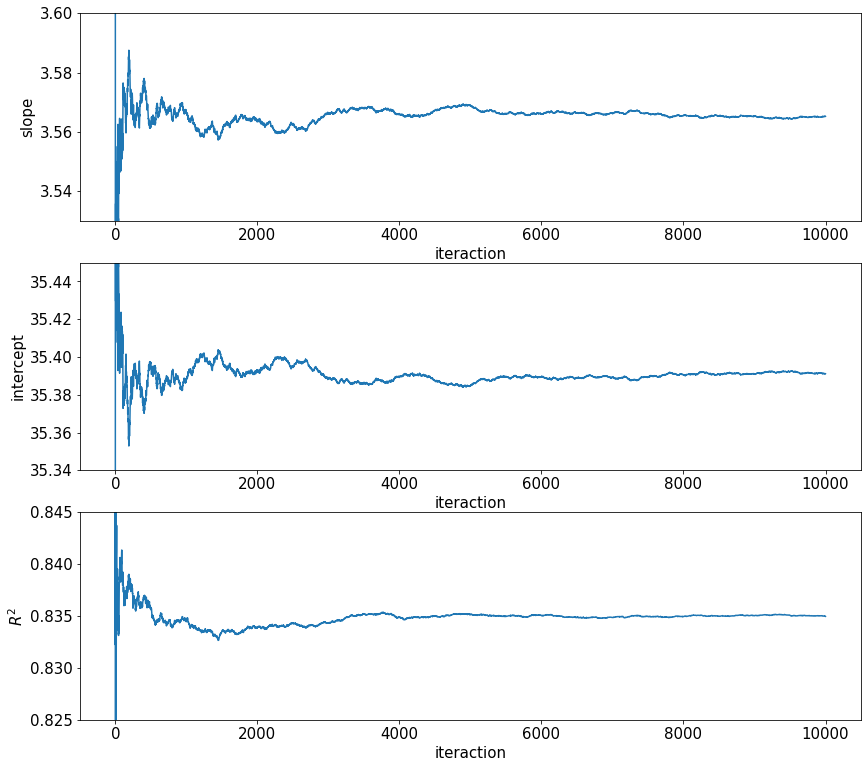

In [150]:
plt.figure(figsize=(14,13))

ax1 = plt.subplot(311)
ax1.plot(range(len(mean_slopes)), mean_slopes)
ax1.set_ylabel('slope', size=15)
ax1.set_xlabel('iteraction', size=15)
ax1.set_ylim(3.53,3.6)

ax2 = plt.subplot(312)
ax2.plot(range(len(mean_intercepts)), mean_intercepts)
ax2.set_ylabel('intercept', size=15)
ax2.set_xlabel('iteraction', size=15)
ax2.set_ylim(35.34,35.45)

ax3 = plt.subplot(313)
ax3.plot(range(len(mean_scores)), mean_scores)
ax3.set_ylabel(r'$R^2$', size=15)
ax3.set_xlabel('iteraction', size=15)
ax3.set_ylim(0.825, 0.845)

plt.show()